In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix  # for evaluating results
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
transform= transforms.ToTensor()

### Load the training set

In [3]:
train_data = datasets.MNIST(root='/Users/asadmolayari/Desktop/my_courses/pytorch/Data', train=True, \
                            download=True, transform=transform)

In [4]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /Users/asadmolayari/Desktop/my_courses/pytorch/Data
    Split: Train
    StandardTransform
Transform: ToTensor()

### Load the test set
There's a companion set of MNIST data containing 10,000 records accessible by setting train=False. As before, torchvision will only download this once, and in the future will look for the local copy.

In [5]:
test_data = datasets.MNIST(root = '/Users/asadmolayari/Desktop/my_courses/pytorch/Data',\
                           train=False, download=True, transform=transform)
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /Users/asadmolayari/Desktop/my_courses/pytorch/Data
    Split: Test
    StandardTransform
Transform: ToTensor()

### Examine a training record

In [6]:
type(train_data)

torchvision.datasets.mnist.MNIST

In [7]:
train_data[2]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [8]:
image, label=train_data[2]
image.shape, label

(torch.Size([1, 28, 28]), 4)

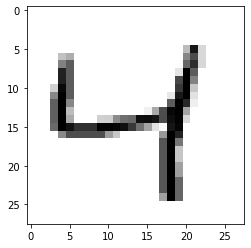

In [9]:
plt.imshow(image.reshape(28,28), cmap="gist_yarg")

In [10]:
torch.manual_seed(101)

train_loader = DataLoader(train_data, batch_size=100, shuffle=True)
test_loader = DataLoader(test_data, batch_size=500, shuffle=False)

bales:  [   0    5    7    8    6    7    9    7    1    3    8    4]


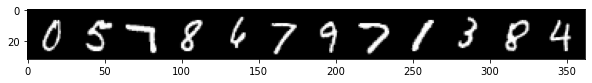

In [11]:
from torchvision.utils import make_grid
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))

for images,labels in train_loader:
    break
    
print('bales: ', labels[:12].numpy())

im = make_grid(images[:12], nrow=12)
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(),(1,2,0)));

In [12]:
class MultilayerPerceptron(nn.Module):
    def __init__(self, in_sz=784, out_sz=10, layers=[120,84]):
        super().__init__()
        self.fc1 = nn.Linear(in_sz, layers[0])
        self.fc2 = nn.Linear(layers[0], layers[1])
        self.fc3 = nn.Linear(layers[1],out_sz)
        
    def forward(self, X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [13]:
torch.manual_seed(101)
model = MultilayerPerceptron()
model

MultilayerPerceptron(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [15]:
for images, labels in train_loader:
    print('Batch shape: ', images.size())
    break

Batch shape:  torch.Size([100, 1, 28, 28])


## Train the model
This time we'll run the test data through the model during each epoch, so that we can compare loss & accuracy on the same plot.

<div class="alert alert-info"><strong>A QUICK NOTE: </strong>In the section below marked &nbsp;<tt><em>#Tally the number of correct predictions</em></tt> &nbsp;we include the code
<pre style='background-color:rgb(217,237,247)'>
predicted = torch.max(y_pred.data, 1)[1]</pre>
This uses the <a href='https://pytorch.org/docs/stable/torch.html#torch.max'><tt><strong>torch.max()</strong></tt></a> function. <tt>torch.max()</tt> returns a tensor of maximum values, and a tensor of the indices where the max values were found. In our code we're asking for the index positions of the maximum values along dimension 1. In this way we can match predictions up to image labels.</div>

In [16]:
import time
start_time=time.time()

epochs=20
train_loss=[]
test_loss=[]
train_correct=[]
test_correct=[]

for i in range(epochs):
    trn_corr = 0
    test_crr = 0
    
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        y_pred = model(X_train.view(100,-1))
        loss = criterion(y_pred, y_train)
        
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr+= batch_corr
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%200 == 0:
            print(f'for the epoch {i} and batch {b}  loss is: {loss} and accuracy is: {100*trn_corr.item()/(b*100)}%' )
        
    train_loss.append(loss)
    train_correct.append(trn_corr)
        
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test.view(500,-1))
            x
            predicted=torch.max(y_val.data, 1)[1]
            test_crr+=(predicted==y_test).sum()
            
    loss =criterion(y_val,y_test)
    test_loss.append(loss)
    test_correct.append(test_crr)
print(f'Duration of the run is : {time.time() -start_time}')

for the epoch 0 and batch 200  loss is: 0.3522172272205353 and accuracy is: 82.695%
for the epoch 0 and batch 400  loss is: 0.32761695981025696 and accuracy is: 87.34%
for the epoch 0 and batch 600  loss is: 0.31156572699546814 and accuracy is: 89.49%
for the epoch 1 and batch 200  loss is: 0.20120714604854584 and accuracy is: 94.8%
for the epoch 1 and batch 400  loss is: 0.14656081795692444 and accuracy is: 95.185%
for the epoch 1 and batch 600  loss is: 0.1269129514694214 and accuracy is: 95.47833333333334%
for the epoch 2 and batch 200  loss is: 0.1362140029668808 and accuracy is: 96.815%
for the epoch 2 and batch 400  loss is: 0.0723576620221138 and accuracy is: 96.79%
for the epoch 2 and batch 600  loss is: 0.042413581162691116 and accuracy is: 96.87833333333333%
for the epoch 3 and batch 200  loss is: 0.09474988281726837 and accuracy is: 97.635%
for the epoch 3 and batch 400  loss is: 0.0639415979385376 and accuracy is: 97.6%
for the epoch 3 and batch 600  loss is: 0.078367069363

## Plot the loss and accuracy comparisons

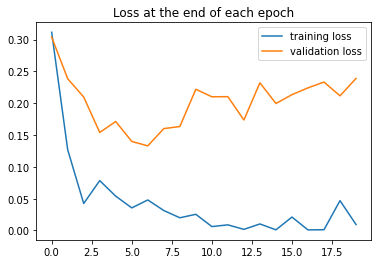

In [17]:
plt.plot(train_loss, label='training loss')
plt.plot(test_loss, label= 'validation loss')
plt.title('Loss at the end of each epoch')
plt.legend()

This shows some evidence of overfitting the training data.

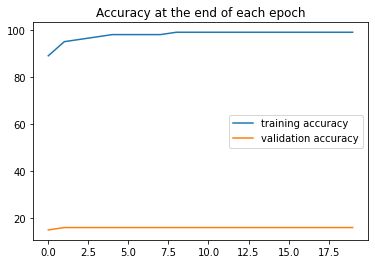

In [18]:
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/600 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [24]:
#test accuracy
test_correct[-1].item()/10000

0.9801

## Display the confusion matrix
This uses scikit-learn, and the predicted values obtained above.

In [25]:
# print a row of values for reference
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()

# print the confusion matrix
print(confusion_matrix(predicted.view(-1), y_test.view(-1)))

[[   0    1    2    3    4    5    6    7    8    9]]

[[  49    0    1    0    1    0    0    0    0    0]
 [   0   60    0    0    0    0    0    0    0    0]
 [   0    0   43    0    0    0    0    0    0    0]
 [   0    0    2   51    0    0    1    0    0    0]
 [   0    0    0    0   47    0    0    0    0    1]
 [   0    0    0    0    0   38    3    0    0    0]
 [   0    0    0    0    0    3   44    0    0    0]
 [   0    0    1    0    2    0    0   59    0    0]
 [   1    0    1    1    0    0    1    0   48    0]
 [   0    0    0    0    0    0    0    0    0   42]]
